In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from composition_stats import ilr, ilr_inv, closure
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
raw_data = pd.read_excel("Datos_Market_copy.xlsx")

data = raw_data.copy()
data.set_index("date", inplace=True)

# Unify the brand names to 4 categories (brand-15, brand-14, brand-35, other)
for i in data["brand"]:
    if i != "brand-15" and i != "brand-14" and i != "brand-35":
        # change the name
        # test_data["brand"].replace(i, "other", inplace=True)
        data["brand"].replace({i: "other"}, inplace=True)


sales = ["volume.sales", "value.sales", "unit.sales"]


pack_size350 = data["pack.size"] == "0 - 350 GR"
pack_size500 = data["pack.size"].isin(["351 - 500 GR"])
pack_size1000 = data["pack.size"].isin(["701 - 1000 GR"])

brand35 = data["brand"].isin(["brand-35"])
brand15 = data["brand"].isin(["brand-15"])
brand14 = data["brand"].isin(["brand-14"])
brandOther = data["brand"].isin(["other"])

variantF = data["variant"].isin(["flavoured"])
variantL = data["variant"].isin(["light"])
variantS = data["variant"].isin(["standard"])
variantV = data["variant"].isin(["vegan"])

supermarketA = data["supermarket"].isin(["supermarket-A"])
supermarketB = data["supermarket"].isin(["supermarket-B"])
supermarketC = data["supermarket"].isin(["supermarket-C"])
supermarketD = data["supermarket"].isin(["supermarket-D"])

/var/folders/r4/_d0jbzx9629841ty8b0gfn040000gn/T/ipykernel_6174/1546303093.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["brand"].replace({i: "other"}, inplace=True)


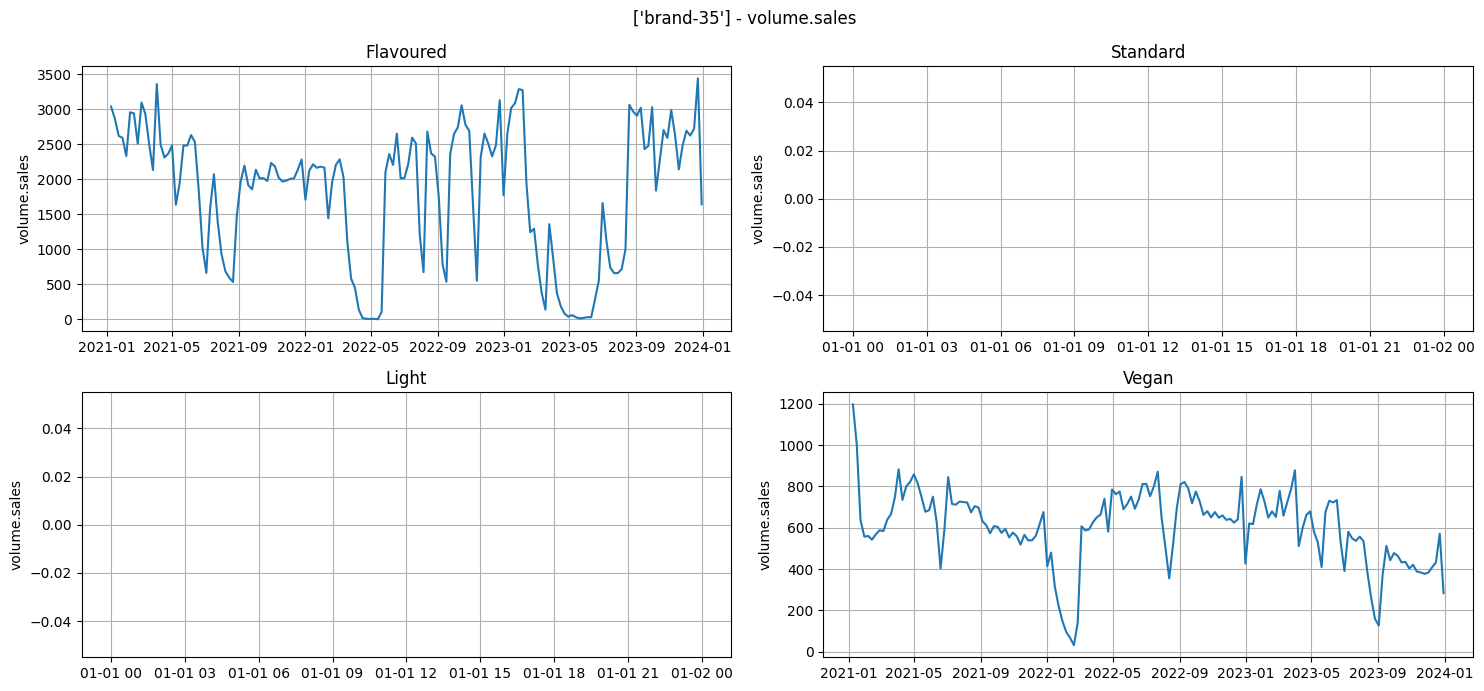

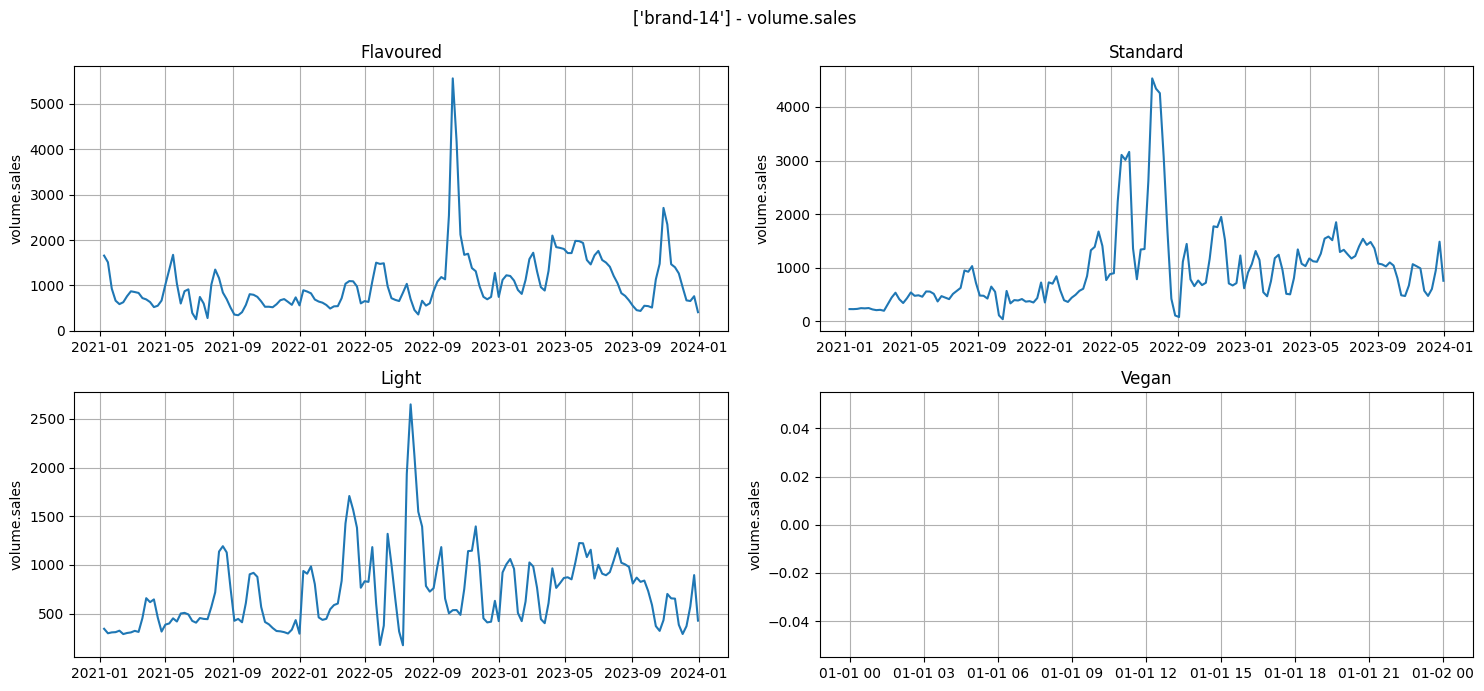

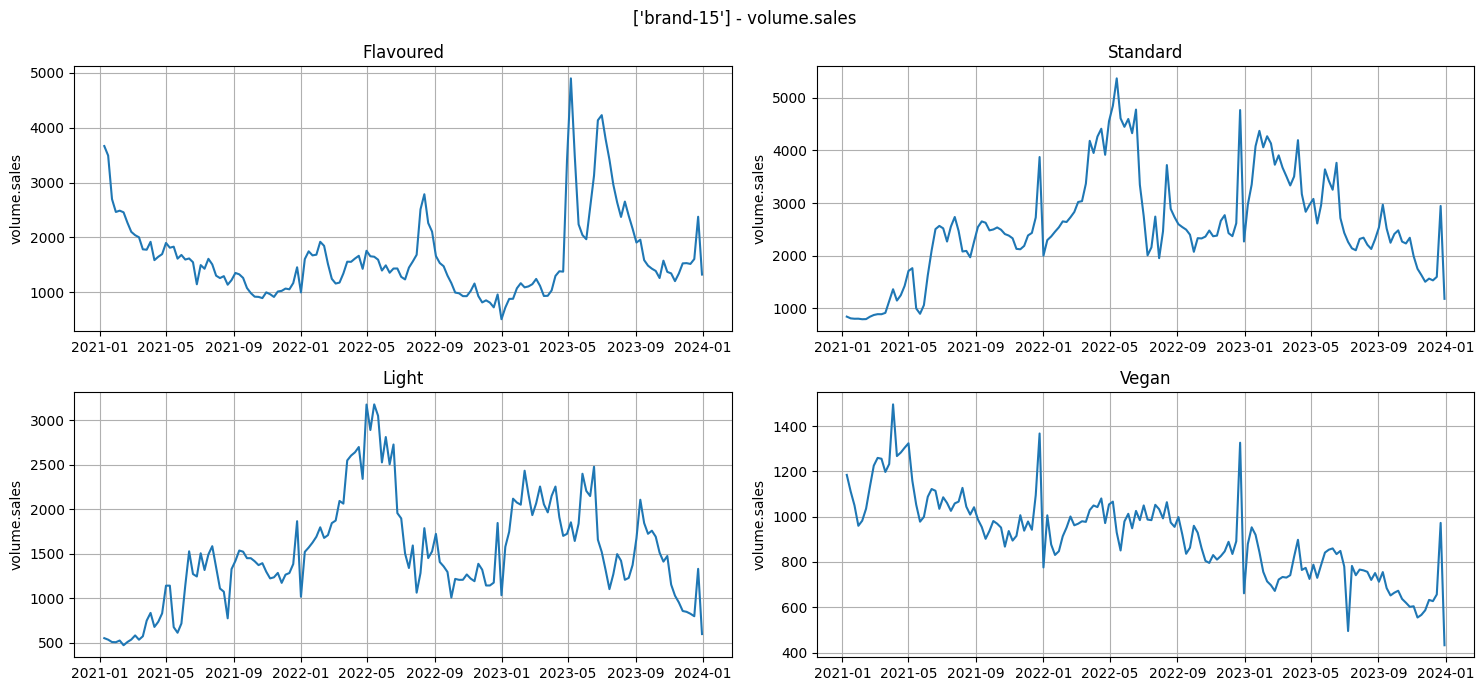

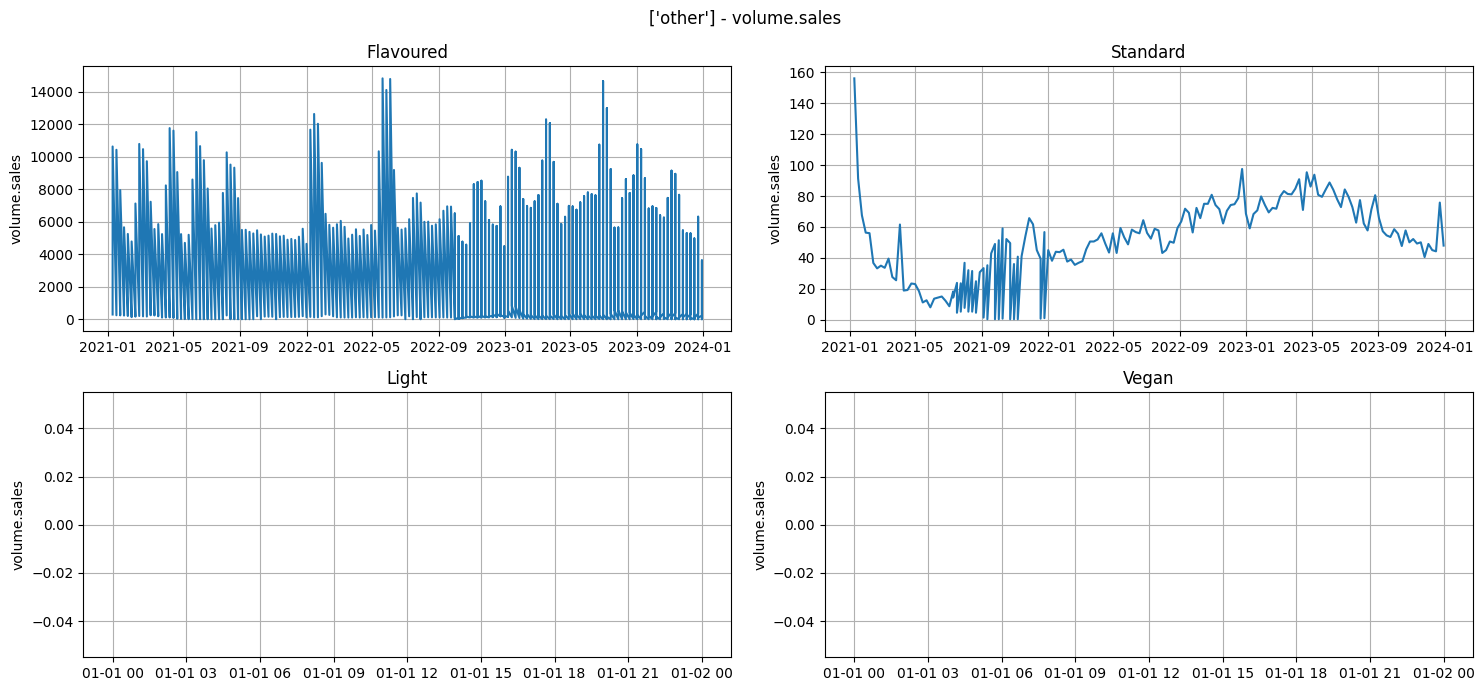

In [11]:
def plot_data(brand, sales):
    fig, ax = plt.subplots(2, 2, figsize=(15, 7))

    ax[0, 0].plot(data[(brand) & (variantF) & (supermarketA) & (pack_size350)][sales])
    ax[0, 0].set_title("Flavoured")
    ax[0, 0].set_ylabel(sales)
    ax[0, 0].grid(True)

    ax[0, 1].plot(data[(brand) & (variantS) & (supermarketA) & (pack_size350)][sales])
    ax[0, 1].set_title("Standard")
    ax[0, 1].set_ylabel(sales)
    ax[0, 1].grid(True)

    ax[1, 0].plot(data[(brand) & (variantL) & (supermarketA) & (pack_size350)][sales])
    ax[1, 0].set_title("Light")
    ax[1, 0].set_ylabel(sales)
    ax[1, 0].grid(True)

    ax[1, 1].plot(data[(brand) & (variantV) & (supermarketA) & (pack_size350)][sales])
    ax[1, 1].set_title("Vegan")
    ax[1, 1].set_ylabel(sales)
    ax[1, 1].grid(True)

    plt.suptitle(f"{data[brand]['brand'].unique()} - {sales}")
    plt.tight_layout()
    plt.show()


plot_data(brand35, "volume.sales")
plot_data(brand14, "volume.sales")
plot_data(brand15, "volume.sales")
plot_data(brandOther, "volume.sales")

NameError: name 'pack_size' is not defined

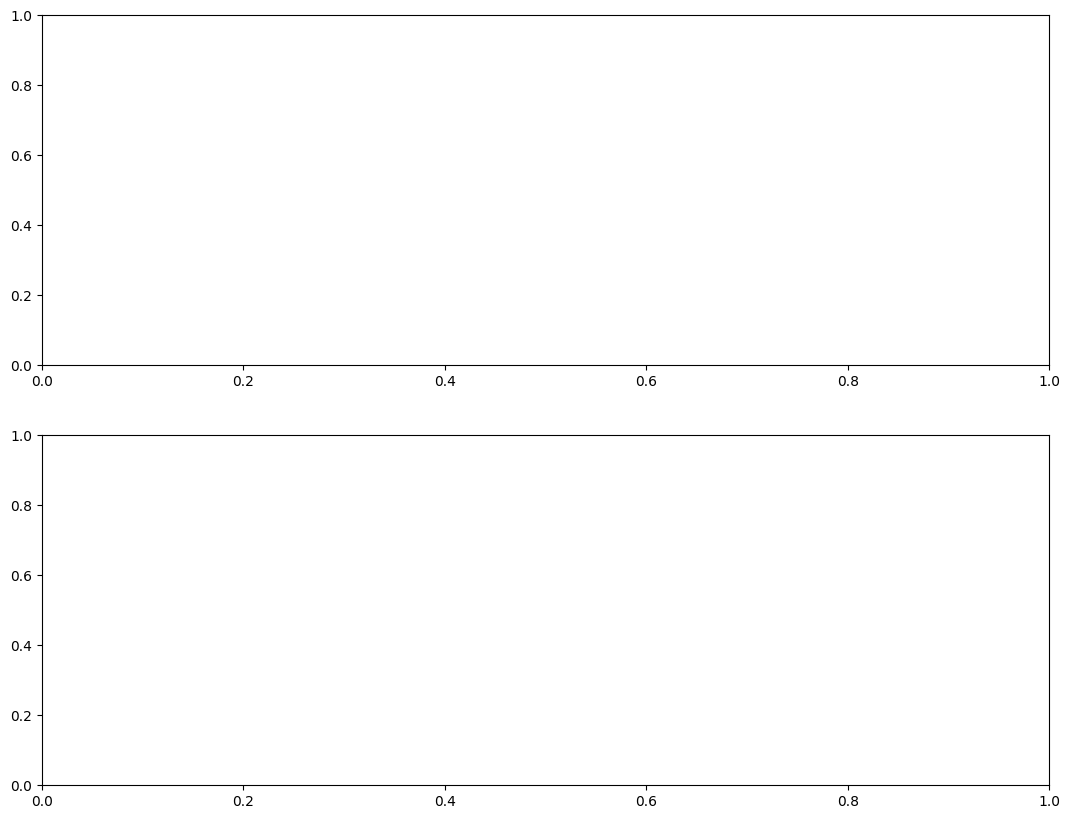

In [7]:
# haz logaritmo de las ventas
def log_graphs(brand, sales):
    fig, ax = plt.subplots(2, 1, figsize=(13, 10))

    ax[0].plot(
        1 / np.log(data[(brand) & (variantF) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantS) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantL) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantV) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].set_title("Log Volume Sales Inverse")
    ax[0].set_ylabel("volume.sales")
    ax[0].set_yscale("log")
    ax[0].grid(True, which="both")
    ax[0].legend(["Flavoured", "Standard", "Light", "Vegan"])

    ax[1].plot(
        data[(brand) & (variantF) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantS) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantL) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantV) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].set_title("Volume Sales")
    ax[1].set_ylabel("volume.sales")
    ax[1].grid(
        True,
    )
    ax[1].legend(["Flavoured", "Standard", "Light", "Vegan"])

    plt.suptitle(f"{data[brand]['brand'].unique()} - {sales}")
    plt.tight_layout()
    plt.show()


log_graphs(brand35, "volume.sales")
# log_graphs(brand15, "volume.sales")
# log_graphs(brand14, "volume.sales")
# log_graphs(brandOther, "volume.sales")

In [ ]:
import statsmodels.api as sm

# Only we selected the pack.size 0 - 350 GR
data_filtered = data[data["pack.size"].isin(["0 - 350 GR", "351 - 500 GR"])]

data_dummies = []


def model(data_filtered=data[(pack_size350) & (brand35)]):
    # Create dummy variables for the supermarket column
    data_dummies = pd.get_dummies(
        data_filtered, columns=["supermarket", "variant"], drop_first=True
    )

    for col in [
        "supermarket_supermarket-B",
        "supermarket_supermarket-C",
        "supermarket_supermarket-D",
        "variant_light",
        "variant_standard",
        "variant_vegan",
    ]:
        data_dummies[col] = data_dummies[col].astype(int)

    X = data_dummies[
        [
            "unit.sales",
            "supermarket_supermarket-B",
            "supermarket_supermarket-C",
            "supermarket_supermarket-D",
            "variant_light",
            "variant_standard",
        ]
    ]

    X = sm.add_constant(X)

    y = data_dummies["volume.sales"]

    # Adjust the model
    model = sm.OLS(y, X).fit()

    model_summary = model.summary()

    return model_summary, data_dummies


model(data)